# Loan status prediction 
##### This dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction)
For further detail refer to *descriptive_analysis.ipynb* or *pre_modelling_process.ipynb* notebooks

In [1]:
import sys
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The following process was conducted carefully in *pre_modelling_process.ipynb* notebook and enhanced in the current one. Refer to the former for further detail

In [2]:
# Load the imputed data
df = pd.read_csv("loan_data_imp.csv") 
####################################################################################################
# Recode variables:
df['Married'] = df['Married'].replace({'Yes': 1, 'No': 0})
df['Education'] = df['Education'].replace({'Graduate': 1, 'Not Graduate': 0})
df['Self_Employed'] = df['Married'].replace({'Yes': 1, 'No': 0})
df['Loan_Status'] = df['Loan_Status'].replace({'Y': 1, 'N': 0})

df2 = df.copy()
####################################################################################################
# Import methods to transform categorical features 
# Many methods do not work with object/string type features and thus these must be recoded
from sklearn.compose import ColumnTransformer
# Categorical features will be recoded using an ordinal encoder for further sequential feature selection
from sklearn.preprocessing import OneHotEncoder

numerical_features = ['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']
columns_to_keep_same = []
columns_to_keep_same.extend(numerical_features)
columns_to_keep_same.extend(['Loan_ID'])
columns_to_keep_same.extend(['Loan_Status'])

categorical_features = df.columns.difference(columns_to_keep_same).tolist()

# Create a ColumnTransformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features without any transformation
)

# The preprocessor will return the transformed data with a different column order from the original df
# Later I will turn the np.array into a pd.DataFrame and for that I need the right column order
import re
# First get the feature names ordered from the preprocessor
preprocessor_feature_names = preprocessor.fit(df).get_feature_names_out()

# Clean the "cat__" and "remainder__" prefixes
cleaned_feature_names = [re.sub(r'^(cat__|remainder__)', '', name) for name in preprocessor_feature_names]

# Transform the data
df = preprocessor.fit_transform(df)
df = pd.DataFrame(df, columns = cleaned_feature_names)

####################################################################################################
# Import the MinMaxScaler from the preprocessing module of sklearn
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns = numerical_features)
# Now combine the non-numerical features data with the normalised features
df_norm = df.drop(numerical_features, axis = 1).join(df_norm)
df_norm.drop('Loan_ID', inplace = True, axis = 1)

for column in df_norm.columns.tolist():
    df_norm[column] = pd.to_numeric(df_norm[column])

####################################################################################################
# Import the train_test_split function from the model_selection module
from sklearn.model_selection import train_test_split

df.sample(frac = 1, random_state = 25).reset_index(drop = True)
df.drop('Loan_ID', inplace = True, axis = 1)

for column in df.columns.tolist():
    df[column] = pd.to_numeric(df[column])

# Split approved loan data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Loan_Status'], axis = 1), df['Loan_Status'], 
                                                    test_size = 0.2, random_state = 25, stratify = df['Loan_Status']) 
# with stratify = df['Loan_Status'] assures that we keep 71% approved and 29% rejected for both train and test sets
# Repeat the process for normalised data
df_norm.sample(frac = 1, random_state = 25).reset_index(drop = True)

X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(df_norm.drop(['Loan_Status'], axis = 1), 
                                                            df_norm['Loan_Status'], 
                                                            test_size = 0.2, random_state = 25, 
                                                            stratify = df_norm['Loan_Status']) 
# We write y_n_train and y_n_train to avoid error messages, but we will only use y_train and y_test as they are exactly the same
####################################################################################################
# Lastly, recode the response 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

####################################################################################################
# Create subset of features according to the results Feature Importance Analysis

# X_train_sub = X_train.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)
# X_test_sub = X_test.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)

# X_n_train_sub = X_n_train.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)
# X_n_test_sub = X_n_test.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)

## Model fitting process (part 2)

### 4. Gradient Boosting Models
Gradient Boosting Models use weak learner classifiers and combine them to obtain a more powerful learner based on the pseudo-residuals obtained iteration after iteration. Most commonly used is the XGB classifier (eXtreme Gradient Boosting)

In [3]:
from xgboost import XGBClassifier 

# Import method for cross validation and hyperparameter tunning 
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
xgb = XGBClassifier(random_state = 25)
xgb.fit(X_train, y_train)

xgb.score(X_test, y_test)

0.7662337662337663

In [5]:
# Fit the model using cross-validation
print(cross_val_score(xgb, X_train, y_train, cv = 25).mean())

0.8294871794871794


In [11]:
# Now let's aim for hyperparameter tunning
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

pipe = Pipeline([("classifier", XGBClassifier(random_state = 25))])

# solver = "liblinear" works fine for small datasets such as the current

search_space = [
    {"classifier" : [XGBClassifier(random_state = 25)],
     "classifier__eta" : [0.1, 0.3, 0.5, 0.7, 1],
     "classifier__gamma" : [0, 0.1, 0.5, 1, 5, 10],
     "classifier__max_depth" : list(range(1,15)),
     
    }
]

#scorer = make_scorer(precision_score, response_method = 'predict')

clf_xgb = GridSearchCV(pipe, search_space, cv = 10, verbose = 3, n_jobs = -1)

In [12]:
clf_xgb.fit(X_train, y_train)
print(clf_xgb.best_estimator_.get_params()["classifier"])

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


In [13]:
clf_xgb.best_score_

0.8548387096774193

In [14]:
clf_xgb.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=25, ...),
 'classifier__eta': 0.1,
 'classifier__gamma': 1,
 'classifier__max_depth': 3}

In [15]:
xgb_best = XGBClassifier(random_state = 25, eta = 0.1, gamma = 1, max_depth = 3)
xgb_best.fit(X_train, y_train)

print(xgb_best.score(X_test, y_test))

0.8181818181818182


In [16]:
# Make predictions on the test set
y_pred = xgb_best.predict(X_test)
y_prob = xgb_best.predict_proba(X_test)#[:, 1]

In [17]:
xgb_precision_score = precision_score(y_test, y_pred)
xgb_recall_score = recall_score(y_test, y_pred)
xgb_roc_auc_score = roc_auc_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)

print('Decision tree presicion score: ' + str(round(xgb_precision_score,3)))
print('Decision tree recall score: ' + str(round(xgb_recall_score,3)))
print('Decision tree ROC score: ' + str(round(xgb_roc_auc_score,3)))
print('Decision tree F1 score: ' + str(round(xgb_f1_score,3)))

Decision tree presicion score: 0.797
Decision tree recall score: 1.0
Decision tree ROC score: 0.682
Decision tree F1 score: 0.887


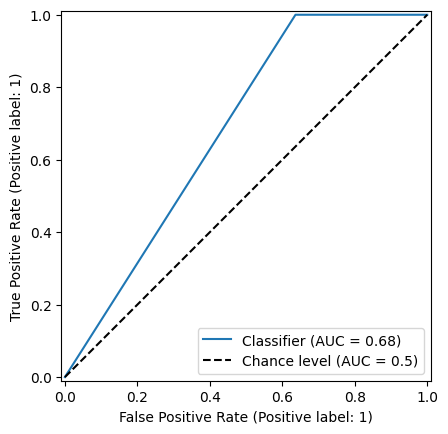

In [18]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

In [19]:
# Import methods to test model's perfrormance
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 0, 55]], dtype=int64)

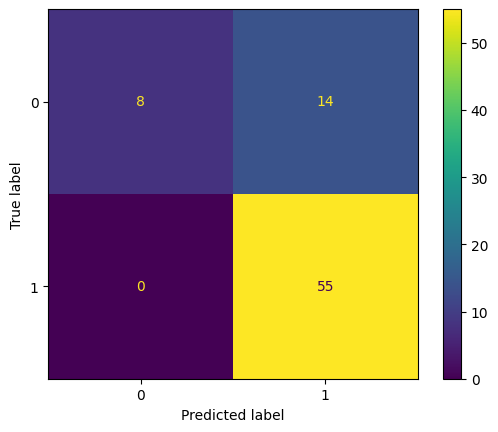

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = xgb_best.classes_)
disp.plot()
plt.show()

The XGB classifier had a similar performance to the logistic regression model. The false positives rate is still a flaw with this model, but the true positives classification was perfect. 